In [1]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import itertools
import keras
# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from keras.models import Sequential,load_model,model_from_json
from keras.layers import Dense, Dropout, LSTM,BatchNormalization,TimeDistributed,Flatten,Bidirectional

In [3]:
filename = '/content/drive/MyDrive/ell319_termpaper/BTP/dataICA.txt'
data=pd.read_table(filename, delimiter = '\t')
data

,Time,Fp1,Fp2,F3,F4,C3,C4,P3,P4,O1,...,CP1,CP2,FC5,FC6,CP5,CP6,FT9,FT10,TP9,TP10
0,0.0,2.96,2.49,2.19,2.31,0.29,-1.91,-1.11,-3.25,-0.91,...,-0.99,-2.73,0.74,-0.48,-0.57,-2.68,2.65,1.77,1.48,2.98
1,2.0,2.79,3.47,2.06,3.24,0.22,-2.17,-0.90,-3.43,-0.58,...,-0.97,-2.15,0.08,0.01,-1.62,-2.95,2.76,1.13,1.36,1.97
2,4.0,2.74,4.37,2.05,4.10,0.29,-2.29,-0.67,-3.60,-0.45,...,-0.83,-1.56,-0.45,0.68,-2.55,-3.26,2.85,0.68,0.88,0.44
3,6.0,2.81,5.08,2.18,4.77,0.54,-2.21,-0.44,-3.69,-0.56,...,-0.56,-0.97,-0.72,1.38,-3.26,-3.55,2.85,0.45,-0.02,-1.43
4,8.0,2.94,5.53,2.46,5.17,0.93,-1.90,-0.21,-3.64,-0.92,...,-0.14,-0.37,-0.69,1.96,-3.71,-3.75,2.73,0.41,-1.28,-3.41
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1160565,2321130.0,-1.27,3.74,-0.26,2.26,1.28,3.91,1.65,1.84,0.77,...,3.62,4.22,-2.75,4.11,0.96,2.41,-3.37,-0.01,-4.98,-27.67
1160566,2321132.0,-0.73,2.78,-0.19,1.19,1.46,3.16,1.74,2.19,1.40,...,3.46,3.08,-2.45,2.62,1.60,2.51,-2.66,-0.19,-4.93,-26.23
1160567,2321134.0,-0.32,1.28,-0.11,0.29,1.84,2.35,1.87,2.41,1.92,...,3.31,2.02,-1.81,0.80,2.41,2.40,-1.97,-1.00,-4.51,-23.07
1160568,2321136.0,-0.12,-0.43,-0.02,-0.37,2.34,1.59,2.01,2.49,2.21,...,3.16,1.17,-0.91,-1.06,3.23,2.09,-1.39,-2.23,-3.77,-18.79


In [4]:
filename_events = '/content/drive/MyDrive/ell319_termpaper/BTP/events.txt'
data_events=pd.read_table(filename_events, delimiter = '\t')
data_events

,number,latency,duration,channel,bvtime,bvmknum,visible,type,code,urevent
0,1.0,1.0,NaN,0.0,1.094600e+09,1.0,NaN,boundary,New Segment,1.0
1,2.0,16401.0,1.0,0.0,NaN,2.0,NaN,A,STIM,2.0
2,3.0,17191.0,1.0,0.0,NaN,3.0,NaN,PP,STIM,3.0
3,4.0,17491.0,1.0,0.0,NaN,4.0,NaN,B,STIM,4.0
4,5.0,18381.0,1.0,0.0,NaN,5.0,NaN,PP,STIM,5.0
...,...,...,...,...,...,...,...,...,...,...
2614,2615.0,1158691.0,1.0,0.0,NaN,257.0,NaN,PP,STIM,2615.0
2615,2616.0,1158851.0,1.0,0.0,NaN,258.0,NaN,Y,STIM,2616.0
2616,2617.0,1159531.0,1.0,0.0,NaN,259.0,NaN,PP,STIM,2617.0
2617,2618.0,1159671.0,1.0,0.0,NaN,260.0,NaN,Z,STIM,2618.0


In [5]:
al = ['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
df_req = pd.DataFrame()
for j in range(26):
    data_a = data;
    df_a = pd.DataFrame()
    for ind in data_events.index:
        if data_events['type'][ind]==al[j]:
            low = data_events['latency'][ind]-250;
            high = data_events['latency'][ind]+250;
            d_x = data_a.loc[(data_a['Time'] >= low) & (data_a['Time'] <= high)]
            df_a = df_a.append(d_x);
        else:
            continue;
    df_a.drop(['Time'], axis=1, inplace=True);
    df_a['Label'] = (j+1);
    df_a.columns = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]
    df_req = df_req.append(df_a);
df_req

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
8076,2.91,5.48,0.07,7.14,-2.14,-1.57,-3.60,-2.73,-5.15,-3.33,...,-3.14,0.13,5.47,-2.63,-1.67,2.19,5.28,-4.84,2.97,1
8077,2.81,5.89,-0.29,7.75,-2.08,-1.09,-3.73,-2.69,-5.35,-3.71,...,-3.25,-0.23,5.79,-2.61,-1.76,2.23,5.08,-5.11,3.36,1
8078,2.19,6.04,-0.77,7.91,-2.16,-0.67,-3.65,-2.27,-4.87,-3.08,...,-3.20,-0.81,5.60,-2.51,-1.46,2.00,4.30,-4.58,3.49,1
8079,1.23,5.95,-1.29,7.64,-2.35,-0.42,-3.38,-1.58,-3.75,-1.60,...,-3.03,-1.52,4.97,-2.35,-0.85,1.60,3.09,-3.39,3.44,1
8080,0.18,5.68,-1.76,7.09,-2.61,-0.40,-2.99,-0.83,-2.20,0.32,...,-2.82,-2.21,4.08,-2.18,-0.07,1.19,1.66,-1.84,3.31,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579956,5.43,5.19,7.26,-0.30,2.93,-3.85,-3.21,-10.24,-6.85,-6.88,...,-7.06,7.43,1.95,-0.63,-2.81,5.62,6.96,1.13,-3.66,26
579957,5.69,6.45,7.64,-0.52,3.31,-3.97,-3.62,-10.86,-7.67,-7.31,...,-7.17,7.79,2.29,-0.21,-3.33,6.59,7.36,0.29,-2.86,26
579958,6.29,7.07,8.04,-0.48,3.82,-4.15,-3.91,-11.48,-8.26,-7.77,...,-7.24,8.13,2.52,0.29,-4.05,7.65,7.49,-0.11,-3.05,26
579959,7.08,7.08,8.39,-0.19,4.35,-4.37,-4.05,-12.01,-8.52,-8.23,...,-7.32,8.41,2.68,0.76,-4.83,8.61,7.43,-0.05,-4.10,26


In [6]:
# pick a large window size of 25 cycles
sequence_length = 20

# function to reshape features into (samples, time steps, features) 
def gen_sequence(id_df, seq_length, seq_cols):
    
    data_matrix = id_df[:,seq_cols]
    
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]

In [7]:
data_req = np.array(df_req)
data_req
print(data_req.shape);
sequence_cols =[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31]

seq_gen = (list(gen_sequence(data_req[data_req[0:,31]==id], sequence_length, sequence_cols))
          for id in np.unique(data_req[0:,31]))

seq_array = np.concatenate(list(seq_gen))
print(seq_array.shape)
seq_array

(325000, 32)
(324480, 20, 32)


array([[[  2.91,   5.48,   0.07, ...,  -4.84,   2.97,   1.  ],
        [  2.81,   5.89,  -0.29, ...,  -5.11,   3.36,   1.  ],
        [  2.19,   6.04,  -0.77, ...,  -4.58,   3.49,   1.  ],
        ...,
        [  2.93,   3.07,   2.89, ...,  -4.8 ,   2.45,   1.  ],
        [  2.12,   1.94,   2.32, ...,  -0.81,   2.  ,   1.  ],
        [  1.53,   1.05,   1.82, ...,   3.12,   1.49,   1.  ]],

       [[  2.81,   5.89,  -0.29, ...,  -5.11,   3.36,   1.  ],
        [  2.19,   6.04,  -0.77, ...,  -4.58,   3.49,   1.  ],
        [  1.23,   5.95,  -1.29, ...,  -3.39,   3.44,   1.  ],
        ...,
        [  2.12,   1.94,   2.32, ...,  -0.81,   2.  ,   1.  ],
        [  1.53,   1.05,   1.82, ...,   3.12,   1.49,   1.  ],
        [  1.18,   0.47,   1.5 , ...,   6.48,   0.85,   1.  ]],

       [[  2.19,   6.04,  -0.77, ...,  -4.58,   3.49,   1.  ],
        [  1.23,   5.95,  -1.29, ...,  -3.39,   3.44,   1.  ],
        [  0.18,   5.68,  -1.76, ...,  -1.84,   3.31,   1.  ],
        ...,
        [  1

In [8]:
from sklearn.utils import shuffle
seq_array = shuffle(seq_array)

In [9]:
train_final=seq_array[0:50000,:,0:31]
test_final=seq_array[50000:70000,:,0:31]
from sklearn import preprocessing
train_label=seq_array[0:50000,0,31]
test_label=seq_array[50000:70000,0,31]
# lb = preprocessing.LabelBinarizer()
# train_label=lb.fit_transform(train_label)
# test_label=lb.fit_transform(test_label)
train_label=train_label.reshape((train_label.shape[0],1))
train_label=train_label.astype('int')
test_label=test_label.astype('int')
print(train_final.shape)
print(train_label.shape)
print(test_final.shape)
print(test_label.shape)

(50000, 20, 31)
(50000, 1)
(20000, 20, 31)
(20000,)


In [10]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit(train_label)
train_label = encoder.transform(train_label)
test_label = encoder.transform(test_label)

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
from keras.utils import np_utils

train_label = np_utils.to_categorical(train_label)

In [12]:
print(train_final.shape)
print(train_label.shape)
print(test_final.shape)
print(test_label.shape)
print(train_label)
print(np.unique(test_label))

(50000, 20, 31)
(50000, 26)
(20000, 20, 31)
(20000,)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]


In [13]:
import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [14]:
nb_features = train_final.shape[2]
nb_out = train_label.shape[1]

model = Sequential()

# model.add(Bidirectional(LSTM( units=512,
#          return_sequences=True),
#          input_shape=(sequence_length, nb_features),
#         ))
# model.add(Dropout(0.2))
# model.add(BatchNormalization())

model.add(Bidirectional(LSTM( units=256,
         return_sequences=True),
         input_shape=(sequence_length, nb_features),
        ))
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(LSTM(
         units=128,
         return_sequences=True))

model.add(BatchNormalization())
model.add(LSTM(
          units=64,
          return_sequences=False))

model.add(BatchNormalization())
model.add(Dense(units=32))
model.add(Dense(units=26, activation='softmax'))
tensorflow.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional (Bidirectiona  (None, 20, 512)          589824    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 20, 512)           0         
                                                                 
 batch_normalization (BatchN  (None, 20, 512)          2048      
 ormalization)                                                   
                                                                 
 lstm_1 (LSTM)               (None, 20, 128)           328192    
                                                                 
 batch_normalization_1 (Batc  (None, 20, 128)          512       
 hNormalization)                                                 
                                                        

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [15]:
train_final = np.asarray(train_final).astype(np.float32)
test_final = np.asarray(test_final).astype(np.float32)
model.fit(train_final,train_label,validation_split=0.2,epochs=20, batch_size=32,verbose=1)

Epoch 1/20
1250/1250 [==============================] - 258s 198ms/step - loss: 3.3039 - accuracy: 0.0491 - val_loss: 3.2545 - val_accuracy: 0.0564
Epoch 2/20
1250/1250 [==============================] - 249s 199ms/step - loss: 3.2454 - accuracy: 0.0590 - val_loss: 3.2445 - val_accuracy: 0.0585
Epoch 3/20
1250/1250 [==============================] - 257s 206ms/step - loss: 3.2245 - accuracy: 0.0654 - val_loss: 3.2258 - val_accuracy: 0.0683
Epoch 4/20
1250/1250 [==============================] - 259s 207ms/step - loss: 3.1995 - accuracy: 0.0759 - val_loss: 3.2015 - val_accuracy: 0.0792
Epoch 5/20
1250/1250 [==============================] - 261s 209ms/step - loss: 3.1640 - accuracy: 0.0910 - val_loss: 3.1782 - val_accuracy: 0.0893
Epoch 6/20
1250/1250 [==============================] - 264s 211ms/step - loss: 3.1105 - accuracy: 0.1072 - val_loss: 3.1459 - val_accuracy: 0.0985
Epoch 7/20
1250/1250 [==============================] - 265s 212ms/step - loss: 3.0454 - accuracy: 0.1280 - val_

In [16]:
test_final = np.asarray(test_final).astype(np.float32)
y_pred_test = np.argmax(model.predict(test_final),axis=1)

y_true_test = test_label

cm_test = confusion_matrix(y_true_test, y_pred_test)
print(cm_test)

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_true_test, y_pred_test)))
print('Micro Precision: {:.2f}'.format(precision_score(y_true_test, y_pred_test, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_true_test, y_pred_test, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_true_test, y_pred_test, average='micro')))

[[359  22  18  17  18  27  10  22  18  16   6  12  37  15  13  24  16  21
   20  10   7   9  18  20  11  15]
 [ 19 358  14  10   9  18  17  15   9  17   9  19  16  19  15  15  18   8
   10   9  20  15  28  37  17  31]
 [ 12  25 331  16  23  34  11  17  22  33  13  22  36  16  28  16   9  27
    3  14  15  27  12  13   9  17]
 [ 27  18  16 318   2  20  21  14  15  11  30  32  12  20  27  27   9  12
   15  19  10   7  11  15  15  14]
 [ 14  14  20   6 387   9   7   9  18  38   7  18  10  13  22  24   8  12
   17  22   9  11   6  13   9  28]
 [ 25  19   8  26  10 357  15  24   9  16  21  14  16  16  17  16  13  29
   12   5  16  16  24  39  13  17]
 [ 19  37  16  28  16  26 270  32   7  17  17  37  33  26  25  16  13  13
   14  12  20  28  18  28  15  22]
 [ 11  17  17   8   9  16  25 383  23   5  16  26  27  12  35   9  14  17
   14   8   3  10   9  11  15   7]
 [ 25  12  29  26  13  11   5  35 347  16  23  24  16  18  11   8  16  28
   16  20  10  15   9  18  20  11]
 [ 15  28  26  18  

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    fig=plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig('confusion_matrix_gender_alpha.png',bbox_inches='tight')

Confusion matrix, without normalization
[[359  22  18  17  18  27  10  22  18  16   6  12  37  15  13  24  16  21
   20  10   7   9  18  20  11  15]
 [ 19 358  14  10   9  18  17  15   9  17   9  19  16  19  15  15  18   8
   10   9  20  15  28  37  17  31]
 [ 12  25 331  16  23  34  11  17  22  33  13  22  36  16  28  16   9  27
    3  14  15  27  12  13   9  17]
 [ 27  18  16 318   2  20  21  14  15  11  30  32  12  20  27  27   9  12
   15  19  10   7  11  15  15  14]
 [ 14  14  20   6 387   9   7   9  18  38   7  18  10  13  22  24   8  12
   17  22   9  11   6  13   9  28]
 [ 25  19   8  26  10 357  15  24   9  16  21  14  16  16  17  16  13  29
   12   5  16  16  24  39  13  17]
 [ 19  37  16  28  16  26 270  32   7  17  17  37  33  26  25  16  13  13
   14  12  20  28  18  28  15  22]
 [ 11  17  17   8   9  16  25 383  23   5  16  26  27  12  35   9  14  17
   14   8   3  10   9  11  15   7]
 [ 25  12  29  26  13  11   5  35 347  16  23  24  16  18  11   8  16  28
   16  20  10 

<Figure size 432x288 with 0 Axes>

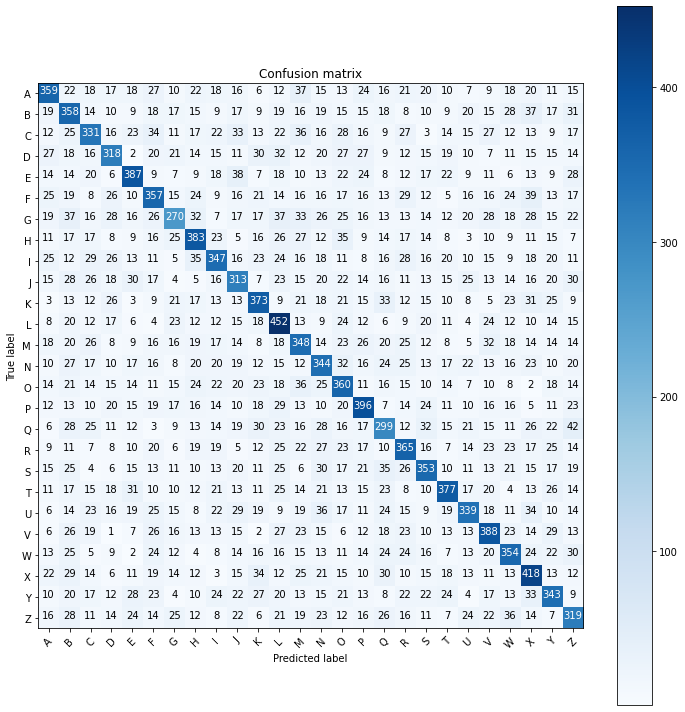

In [18]:
class_names=['A','B','C','D','E','F','G','H','I','J','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y','Z']
plt.figure()
plt.rcParams["figure.figsize"] = (10,10)
plot_confusion_matrix(cm_test, classes=class_names,
                      title='Confusion matrix')
plt.show()